## How to use ciso on unstructured grids

In [1]:
import warnings
import iris


url = "http://test.opendap.org:8080/opendap/ugrid/NECOFS_GOM3_FORECAST.nc"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(url)

In [2]:
salt = cubes.extract_cube("sea_water_salinity")[-1, :, :]  # Last time step.

lon = salt.coord(axis="X").points
lat = salt.coord(axis="Y").points

In [3]:
p = salt.coord("sea_surface_height_above_reference_ellipsoid").points
q = salt.data

In [4]:
import numpy as np
from ciso import zslice


p0 = -25
isoslice = zslice(q, p, -50)

In [5]:
import numpy.ma as ma


# Cannot tricontourf with NaNs.
isoslice = ma.masked_invalid(isoslice)
vmin, vmax = isoslice.min(), isoslice.max()
isoslice = isoslice.filled(fill_value=-999)

In [6]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13), subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = gl.top_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines("50m")
    return fig, ax

In [7]:
import gridgeo


grid = gridgeo.GridGeo(url, standard_name="sea_water_salinity")

/home/runner/work/ciso/ciso/.pixi/envs/py312/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


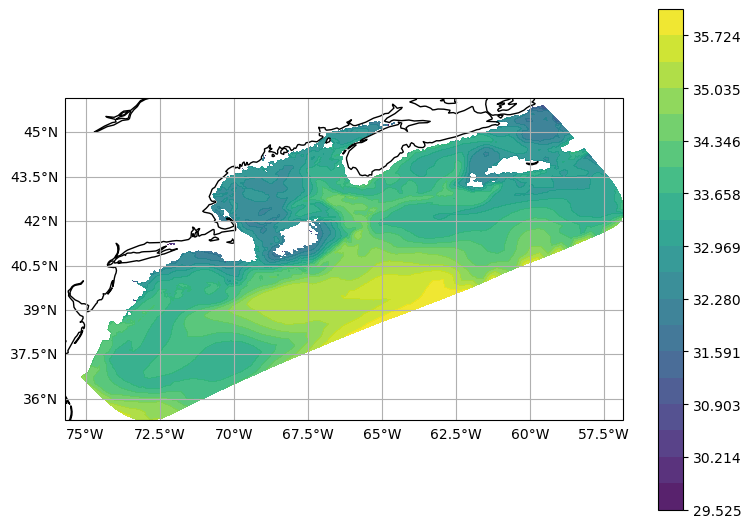

In [8]:
fig, ax = make_map()
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
ax.set_extent(extent)

levels = np.linspace(vmin, vmax, 20)

kw = {"alpha": 0.9, "levels": levels}
cs = ax.tricontourf(grid.triang, isoslice, **kw)

kw = {"shrink": 0.5, "orientation": "vertical"}
cbar = fig.colorbar(cs, **kw)